## Object detection Examples

### D-FINE

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


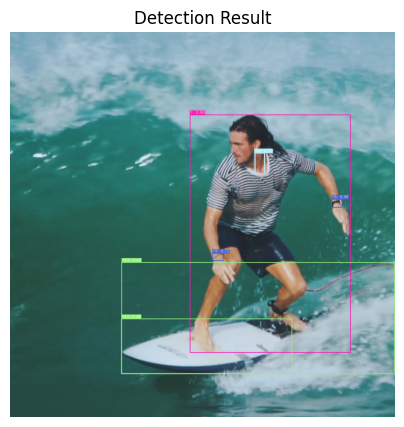

In [1]:
from ezonnx import DFINE,visualize_images
det = DFINE("s")  # you can choose "s", "m", "l", "x"
ret = det("images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### RTMDet

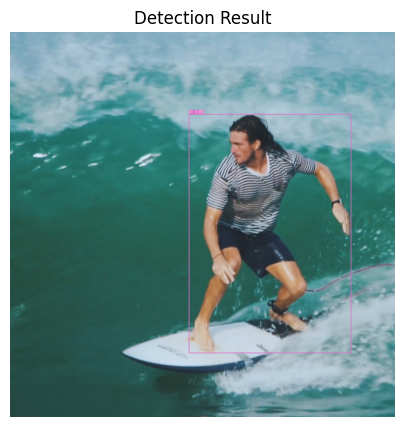

In [2]:
from ezonnx import RTMDet,visualize_images
det = RTMDet("m-person")  # you can choose "n-person","m-person","n-hand","tiny-coco","s-coco","m-coco","l-coco","x-coco")
ret = det("images/surf.jpg")
visualize_images("Detection Result",ret.visualized_img)

### DWPose - person whole body keypoint detection

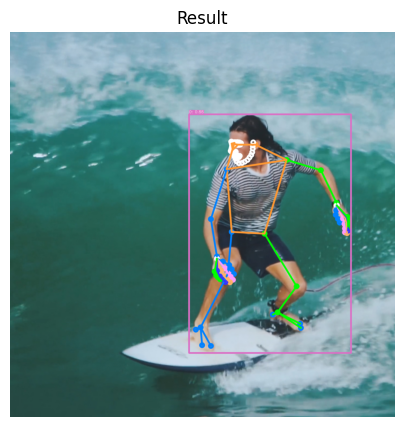

In [2]:
from ezonnx import DWPose,visualize_images
pose = DWPose()
result = pose("images/surf.jpg")
visualize_images("Result",result.visualized_img)

### RTMPose - person pose estimation

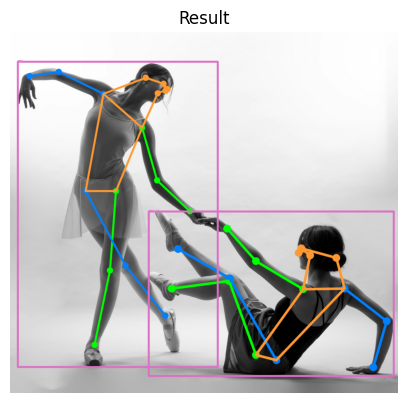

In [3]:
from ezonnx import RTMPose,visualize_images
pose = RTMPose("l") 
result = pose("images/multi_person.jpg")
visualize_images("Result",result.visualized_img)

### RTMW - person whole body keypoint detection

2025-09-03 12:41:38.719379 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1709'. It is not used by any node and should be removed from the model.
2025-09-03 12:41:38.719400 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1701'. It is not used by any node and should be removed from the model.
2025-09-03 12:41:38.719421 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1706'. It is not used by any node and should be removed from the model.


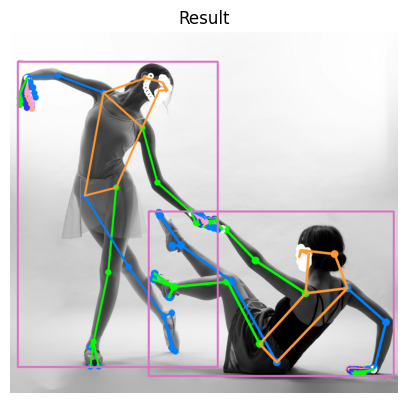

In [2]:
from ezonnx import RTMW,visualize_images
pose = RTMW("l-384") 
result = pose("images/multi_person.jpg")
visualize_images("Result",result.visualized_img)

### MotionBERT - 2D to 3D pose conversion

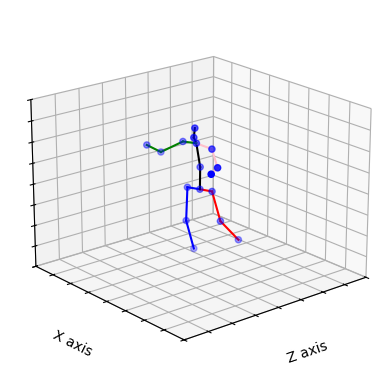

In [1]:
from ezonnx import MotionBERT3D,show_3d_poses
mbert = MotionBERT3D(n_frames=27)
poses_3d, poses_2d = mbert("images/dance.mp4",stride=3)
show_3d_poses(poses_3d)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Video path
video_path = "images/dance.mp4"
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Square crop size
crop_size = min(w, h)
x0 = (w - crop_size) // 2
y0 = (h - crop_size) // 2

# Output video size (side by side)
out_w = crop_size * 2
out_h = crop_size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('images/dance_output.mp4', fourcc, fps, (out_w, out_h))

# Joint connections for 3D plot
connections = [
    (0, 1), (1, 2), (2, 3),
    (0, 4), (4, 5), (5, 6),
    (0, 7), (7, 8), (8, 9), (9, 10),
    (8, 11), (11, 12), (12, 13),
    (8, 14), (14, 15), (15, 16)
]

# Match the number of frames in poses_3d and video frames
N = min(len(poses_3d), frame_count)

for i in range(N):
    ret, frame = cap.read()
    if not ret:
        break
    # Left: center square crop
    crop = frame[y0:y0+crop_size, x0:x0+crop_size]

    # Right: generate 3D plot image
    pose = poses_3d[i]
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pose[:,2], pose[:,0], pose[:,1], color='blue')
    for k, (a, b) in enumerate(connections):
        if k < 3: color = "blue"
        elif k < 6: color = "red"
        elif k < 10: color = "black"
        elif k < 13: color = "pink"
        else: color = "green"
        ax.plot([pose[a,2], pose[b,2]], [pose[a,0], pose[b,0]], [pose[a,1], pose[b,1]], color=color)
    ax.set_xlim([-1, 1])
    ax.set_ylim([1, -1])
    ax.set_zlim([1, -1])
    ax.set_xlabel('Z axis')
    ax.set_ylabel('X axis')
    ax.set_zlabel('Y axis')
    ax.view_init(elev=20, azim=180 + i*1)  # rotation
    # plt.axis('off')
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
    fig.tight_layout(pad=0)
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    img = img[..., :3]  # remove alpha channel if present
    plt.close(fig)
    # Resize
    img = cv2.resize(img, (crop_size, crop_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Concatenate left and right
    combined = np.concatenate([crop, img], axis=1)
    out.write(combined)

cap.release()
out.release()